In [36]:
import uproot4 as upr
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import particle
import ROOT as r
import math
import numpy as np

In [2]:
def get_mass_from_pdgid(pdgid):
    try:
        particle_info = particle.Particle.from_pdgid(pdgid)
        if particle_info is not None:
            return particle_info.mass
        else:
            return np.NaN
    except Exception as e:
        print(f"Error occurred for PDG ID {pdgid}: {e}")
        return np.NaN

def calculate_tof_ns(distance_mm, beta):
    c = 3e8  # Velocità della luce in m/s
    distance_m = distance_mm / 1000  # Convertire la distanza da mm a metri
    tof_s = distance_m / (beta * c)  # Calcolare il tempo di volo in secondi
    tof_ns = tof_s * 1e9  # Convertire il tempo di volo in nanosecondi
    return tof_ns

def GetLinePoints(vx, vy, vz, vtx, vty, vtz):
    x, y, z = ([] for i in range(3))
    
    # Normalize the direction vector
    norm = np.sqrt(vx**2 + vy**2 + vz**2)
    direction = np.array([vx / norm, vy / norm, vz / norm])
    
    start = np.array([vtx, vty, vtz])
    
    for i in np.arange(0, 4, 0.1):
        # Compute the point on the line at step i
        point = start + i * direction
        # Append the coordinates to the respective lists
        x.append(point[0])
        y.append(point[1])
        z.append(point[2])
    
    return {"x":x, "y":y,"z" : z}

In [3]:
sand_center = [0, -2384.73, 23910]
sand_radius = 2000
theta = np.linspace(0, 2*np.pi, 100000)
z_sand = sand_center[2] + sand_radius * np.cos(theta)
y_sand = sand_center[1] + sand_radius * np.sin(theta)

def plotEvent(test_event, 
              tests_event_primaries, 
              test_event_fired_cells, 
              best_fired_cell):

    barrel_cells = test_event_fired_cells[test_event_fired_cells.Fired_Cells_mod < 30]
    endcap_cells = test_event_fired_cells[test_event_fired_cells.Fired_Cells_mod >= 30]

    neutron_first_hit = tests_event_primaries[tests_event_primaries.PDG==2112][['PrimariesFirstHitECAL_x','PrimariesFirstHitECAL_y','PrimariesFirstHitECAL_z']]

    neutron_true_trj = GetLinePoints(test_event['ExpectedHadronSystP3fX'].iloc[0], 
                                     test_event['ExpectedHadronSystP3fY'].iloc[0], 
                                     test_event['ExpectedHadronSystP3fZ'].iloc[0], 
                                     test_event['Interaction_vtxX'].iloc[0], 
                                     test_event['Interaction_vtxY'].iloc[0], 
                                     test_event['Interaction_vtxZ'].iloc[0]
                                     )

    fig, ax = plt.subplots(1,2,figsize=(18,8))

    ax[0].plot(z_sand, y_sand, linestyle='-', color='red', label = 'SAND')

    ax[1].vlines(sand_center[2] - sand_radius, -1650, 1650, color='red', label='SAND')
    ax[1].vlines(sand_center[2] + sand_radius, -1650, 1650, color='red')
    ax[1].hlines(-1650, sand_center[2] - sand_radius, sand_center[2] + sand_radius, color='red')
    ax[1].hlines(1650,  sand_center[2] - sand_radius, sand_center[2] + sand_radius,color='red')

    # -----------------------------------------------------------------------------------

    ax[0].scatter(x=barrel_cells['Fired_Cells_z'], 
                  y=barrel_cells['Fired_Cells_y'], 
                  label='ECAL fired cells', marker='x', color='gray')
    
    ax[0].scatter(x=endcap_cells['Fired_Cells_z'], 
                  y=endcap_cells['hit_reco_y'],
                  marker='x', color='gray')

    ax[0].scatter(x=test_event['ExpectedNeutronArrivalPositionECALfZ'], 
                  y=test_event['ExpectedNeutronArrivalPositionECALfY'], 
                  label='expected entry point')

    ax[0].scatter(x=neutron_first_hit['PrimariesFirstHitECAL_z'], 
                  y=neutron_first_hit['PrimariesFirstHitECAL_y'], 
                  label='edepsim ECAL 1st hit')

    ax[0].plot(np.array(neutron_true_trj['z'])*1e3, 
               np.array(neutron_true_trj['y'])*1e3, 
               color='gray', label='expected neutron')
    
    # -----------------------------------------------------------------------------------
    
    ax[1].plot(np.array(neutron_true_trj['z'])*1e3, 
               np.array(neutron_true_trj['x'])*1e3, 
               color='gray', label='expected neutron')

    ax[1].scatter(x=barrel_cells['Fired_Cells_z'], 
                  y=barrel_cells['hit_reco_x'], 
                  label='ECAL fired cells', marker='x', color='gray')
    
    ax[1].scatter(x=endcap_cells['Fired_Cells_z'], 
                  y=endcap_cells['Fired_Cells_x'], 
                  label='ECAL fired cells', marker='x', color='gray')

    ax[1].scatter(x=test_event['ExpectedNeutronArrivalPositionECALfZ'], 
                  y=test_event['ExpectedNeutronArrivalPositionECALfX'], 
                  label='expected entry point')

    ax[1].scatter(x=neutron_first_hit['PrimariesFirstHitECAL_z'], 
                  y=neutron_first_hit['PrimariesFirstHitECAL_x'], 
                  label='edepsim ECAL 1st hit')

    # -----------------------------------------------------------------------------------
        
    # if barrel it has no x coordinate -> take the one reco
    if(best_fired_cell.Fired_Cells_id.values[0] < 250000):
        ax[0].scatter(x=best_fired_cell['Fired_Cells_z'], 
                      y=best_fired_cell['Fired_Cells_y'], 
                      label='candidate cell', marker='x', color='black')
        
        ax[1].scatter(x=best_fired_cell['Fired_Cells_z'], 
                      y=best_fired_cell['hit_reco_x'], 
                      label='candidate cell', marker='x', color='black')
    else:
    # if endcap it has no y coordinate -> take the one reco
        ax[0].scatter(x=best_fired_cell['Fired_Cells_z'], 
                      y=best_fired_cell['hit_reco_y'], 
                      label='candidate cell', marker='x', color='black', s=70)
        
        ax[1].scatter(x=best_fired_cell['Fired_Cells_z'], 
                      y=best_fired_cell['Fired_Cells_x'], 
                      label='candidate cell', marker='x', color='black', s=70)

    ax[0].legend()

In [4]:
tree = upr.open("/storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.0.ecal-digit.analysed.root")

In [5]:
tree['digit_extended'].keys()[-20:]

['ExpectedHadronSystP3',
 'ExpectedHadronSystEnergy',
 'ExpectedNeutronArrivalPositionECAL',
 'ExpectedFiredModuleByNeutron',
 'MissingTransverseMomentum',
 'NofEventFiredModules',
 'EventFiredModules',
 'Fired_Cells_mod',
 'Fired_Cells_id',
 'Fired_Cells_x',
 'Fired_Cells_y',
 'Fired_Cells_z',
 'Fired_Cells_tdc1',
 'Fired_Cells_tdc2',
 'isCellComplete',
 'Cell_Reconstructed_hits',
 'STDistToNeutronExpectedHit',
 'NofEventClusters',
 'ClusterX4',
 'Cluster2Vertex4Distance']

In [12]:
primaries = tree['digit_extended'].arrays(['FileName',
 'EventId',
 'EventType',
 'CCQEonHydrogen',
 'Interaction_vtxX',
 'Interaction_vtxY',
 'Interaction_vtxZ',
 'Interaction_vtxT',
 'PrimariesPDG',
 'PrimariesP4',
 'PrimariesFirstHitECAL',
 'PrimariesEDepECAL',
 'PrimariesEmissionAngle',
 ],library='pd')

new_columns = {
    ('EventType','','')                           : 'EventType',
    ('FileName','','')                            : 'FileName',
    ('EventId','','')                             : 'EventId',
    ('CCQEonHydrogen','','')                      : 'CCQEonHydrogen',
    ('PrimaryStateHadronicSystemTotalKinE','','') : 'PrimaryStateHadronicSystemTotalKinE',
    ('PrimariesPDG','','')                        : 'PDG',
    ('Interaction_vtxX','','')                    : 'Interaction_vtxX',
    ('Interaction_vtxY','','')                    : 'Interaction_vtxY',
    ('Interaction_vtxZ','','')                    : 'Interaction_vtxZ',
    ('Interaction_vtxT','','')                    : 'Interaction_vtxT',
    ('PrimariesP4','fP','fX')                     : 'Px',
    ('PrimariesP4','fP','fY')                     : 'Py',
    ('PrimariesP4','fP','fZ')                     : 'Pz',
    ('PrimariesP4','fE','')                       : 'E',
    ('PrimariesFirstHitECAL', 'fP', 'fX')         : 'PrimariesFirstHitECAL_x',
    ('PrimariesFirstHitECAL', 'fP', 'fY')         : 'PrimariesFirstHitECAL_y',
    ('PrimariesFirstHitECAL', 'fP', 'fZ')         : 'PrimariesFirstHitECAL_z',
    ('PrimariesFirstHitECAL', 'fE', '')           : 'PrimariesFirstHitECAL_t',
    ('PrimariesEDepECAL', '', '')                 : 'PrimariesEDepECAL',
    ('PrimariesEmissionAngle', '', '')            : 'PrimariesEmissionAngle',
}


# Rename the columns
primaries = primaries.rename(columns=new_columns)
primaries = primaries.set_index(['FileName','EventId'])

primaries["mass"] = primaries['PDG'].apply(get_mass_from_pdgid)
primaries["E_kin"] = primaries['E'] - primaries['mass']
primaries["gamma"] = primaries['E'] / (primaries["mass"])
primaries["beta"] =np.sqrt(1. - 1. / primaries["gamma"].values**2)

primaries['dist_Vtx2ECAL'] = np.sqrt((primaries['PrimariesFirstHitECAL_x'] - primaries['Interaction_vtxX']*1e3)**2 + 
                                     (primaries['PrimariesFirstHitECAL_y'] - primaries['Interaction_vtxY']*1e3)**2 + 
                                     (primaries['PrimariesFirstHitECAL_z'] - primaries['Interaction_vtxZ']*1e3)**2)

primaries

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in sqrt


EventType  \
FileName                                           EventId             
events-in-SANDtracker.2.gtrac.root:gRooTracker:926 926           DIS   
                                                   926           DIS   
                                                   926           DIS   
                                                   926           DIS   
                                                   926           DIS   
...                                                              ...   
events-in-SANDtracker.2.gtrac.root:gRooTracker:893 893           COH   
                                                   893           COH   
                                                   893           COH   
events-in-SANDtracker.2.gtrac.root:gRooTracker:905 905           QES   
                                                   905           QES   

                                                            CCQEonHydrogen  \
FileName                                           EventId                   
events-in-SANDtracker.2.gtrac.root:gRooTracker:926 926                   0   
                                                   926                   0   
                                                   926                   0   
                                                   926                   0   
                                                   926                   0   
...                                                                    ...   
events-in-SANDtracker.2.gtrac.root:gRooTracker:893 893                   0   
                                                   893                   0   
                                                   893                   0   
events-in-SANDtracker.2.gtrac.root:gRooTracker:905 905                   0   
                                                   905                   0   

                                                            Interaction_vtxX  \
FileName                                           EventId                     
events-in-SANDtracker.2.gtrac.root:gRooTracker:926 926             -0.266116   
                                                   926             -0.266116   
                                                   926             -0.266116   
                                                   926             -0.266116   
                                                   926             -0.266116   
...                                                                      ...   
events-in-SANDtracker.2.gtrac.root:gRooTracker:893 893             -0.234753   
                                                   893             -0.234753   
                                                   893             -0.234753   
events-in-SANDtracker.2.gtrac.root:gRooTracker:905 905             -0.742924   
                                                   905             -0.742924   

                                                            Interaction_vtxY  \
FileName                                           EventId                     
events-in-SANDtracker.2.gtrac.root:gRooTracker:926 926             -2.644497   
                                                   926             -2.644497   
                                                   926             -2.644497   
                                                   926             -2.644497   
                                                   926             -2.644497   
...                                                                      ...   
events-in-SANDtracker.2.gtrac.root:gRooTracker:893 893             -3.343410   
                                                   893             -3.343410   
                                                   893             -3.343410   
events-in-SANDtracker.2.gtrac.root:gRooTracker:905 905             -2.958888   
                                                   905             -2.958888   

                         

In [10]:
df = tree['digit_extended'].arrays(['FileName',
 'EventId',
 'EventType',
 'CCQEonHydrogen',
  'Interaction_vtxX',
 'Interaction_vtxY',
 'Interaction_vtxZ',
#  'FinalStateLeptonEmissionAngle',
 'PrimaryStateHadronicSystemTotalKinE',
#  'PrimariesPDG',
#  'PrimariesFirstHitECAL',
#  'PrimariesEDepECAL',
#  'PrimariesEmissionAngle',
#  'ExpectedNeutrinoP4FromMuon',
 'ExpectedHadronSystP3',
#  'ExpectedHadronSystEnergy',
 'ExpectedNeutronArrivalPositionECAL',
 'ExpectedFiredModuleByNeutron',
#  'NofEventFiredModules',
#  'EventFiredModules',
#  'NofEventClusters',
#  'ClusterX4',
#  'Cluster2Vertex4Distance'
 ],library='pd')

new_columns = {
    ('EventType','','')                              : 'EventType',
    ('FileName','','')                               : 'FileName',
    ('EventId','','')                                : 'EventId',
    ('CCQEonHydrogen','','')                         : 'CCQEonHydrogen',
    ('PrimaryStateHadronicSystemTotalKinE','','')    : 'PrimaryStateHadronicSystemTotalKinE',
    ('PrimariesPDG','','')                           : 'PrimariesPDG',
    ('Interaction_vtxX', '', '')                     : 'Interaction_vtxX',
    ('Interaction_vtxY', '', '')                     : 'Interaction_vtxY',
    ('Interaction_vtxZ', '', '')                     : 'Interaction_vtxZ',
    # NEUTRON PREDICTIONS
    ('ExpectedHadronSystP3fX', '', '')               : 'ExpectedHadronSystPx',
    ('ExpectedHadronSystP3fY', '', '')               : 'ExpectedHadronSystPy',
    ('ExpectedHadronSystP3fZ', '', '')               : 'ExpectedHadronSystPz',
    ('ExpectedNeutronArrivalPositionECALfX', '', '') : 'ExpectedNeutronArrivalPositionECALfX',
    ('ExpectedNeutronArrivalPositionECALfY', '', '') : 'ExpectedNeutronArrivalPositionECALfY',
    ('ExpectedNeutronArrivalPositionECALfZ', '', '') : 'ExpectedNeutronArrivalPositionECALfZ',
    ('ExpectedFiredModuleByNeutron', '', '')         : 'ExpectedFiredModuleByNeutron',
    # ('ClusterX4', 'fP', 'fX')                     : 'ClusterX4_x',
    # ('ClusterX4', 'fP', 'fY')                     : 'ClusterX4_y',
    # ('ClusterX4', 'fP', 'fZ')                     : 'ClusterX4_z',
    # ('ClusterX4', 'fE', '')                       : 'ClusterX4_t',
    # ('Cluster2Vertex4Distance', 'fP', 'fX')       : 'Cluster2Vertex4Distance_x',
    # ('Cluster2Vertex4Distance', 'fP', 'fY')       : 'Cluster2Vertex4Distance_y',
    # ('Cluster2Vertex4Distance', 'fP', 'fZ')       : 'Cluster2Vertex4Distance_z',
    # ('Cluster2Vertex4Distance', 'fE', '')         : 'Cluster2Vertex4Distance_t',
}


# Rename the columns
df = df.rename(columns=new_columns)

df = df.set_index(['FileName','EventId'])

df['dist_Vtx2ECAL'] = np.sqrt((df['ExpectedNeutronArrivalPositionECALfX'] - df['Interaction_vtxX']*1e3)**2 + 
                              (df['ExpectedNeutronArrivalPositionECALfY'] - df['Interaction_vtxY']*1e3)**2 + 
                              (df['ExpectedNeutronArrivalPositionECALfZ'] - df['Interaction_vtxZ']*1e3)**2)

df['ExpectedHadronSystPtot'] = np.sqrt(df['ExpectedHadronSystP3fX']**2 + 
                                       df['ExpectedHadronSystP3fY']**2 + 
                                       df['ExpectedHadronSystP3fZ']**2) * 1e3

df["ExpectedNeutronE"]      = np.sqrt(df['ExpectedHadronSystPtot'] ** 2 + 939.565413 ** 2)
df["ExpectedNeutronGamma"]  = df["ExpectedNeutronE"]/ 939.565413
df['ExpectedNeutronBeta']   = np.sqrt(1. - 1. / df["ExpectedNeutronGamma"].values**2)
df['ExpectedNeutronCrossingTimeECAL'] = df.apply(lambda row: calculate_tof_ns(row['dist_Vtx2ECAL'], row['ExpectedNeutronBeta']), axis=1)
df

,,EventType,CCQEonHydrogen,Interaction_vtxX,Interaction_vtxY,Interaction_vtxZ,PrimaryStateHadronicSystemTotalKinE,ExpectedHadronSystP3fX,ExpectedHadronSystP3fY,ExpectedHadronSystP3fZ,ExpectedNeutronArrivalPositionECALfX,ExpectedNeutronArrivalPositionECALfY,ExpectedNeutronArrivalPositionECALfZ,ExpectedFiredModuleByNeutron,dist_Vtx2ECAL,ExpectedHadronSystPtot,ExpectedNeutronE,ExpectedNeutronGamma,ExpectedNeutronBeta,ExpectedNeutronCrossingTimeECAL
FileName,EventId,,,,,,,,,,,,,,,,,,,
events-in-SANDtracker.2.gtrac.root:gRooTracker:926,926,DIS,0,-0.266116,-2.644497,22.889151,5.353876,0.612343,-1.608309,1.377046,410.660474,-4422.039476,24411.096814,17,2435.980980,2204.059642,2395.967878,2.550081,0.919904,8.826942
events-in-SANDtracker.2.gtrac.root:gRooTracker:927,927,QES,1,-1.240262,-2.808265,24.922758,0.110047,0.297158,0.325142,0.157750,158.185074,-1278.122110,25665.138301,18,2201.845238,467.873277,1049.613533,1.117127,0.445758,16.465189
events-in-SANDtracker.2.gtrac.root:gRooTracker:929,929,RES,0,-0.536582,-3.552464,23.134177,0.000000,-0.414627,0.501984,0.431296,-1751.054663,-2082.114790,24397.474089,40,2287.529549,780.973477,1221.762144,1.300348,0.639219,11.928775
events-in-SANDtracker.2.gtrac.root:gRooTracker:932,932,QES,0,-0.759041,-1.420677,23.100418,0.037145,-0.112462,0.019056,0.015567,-1802.342380,-1243.894965,23244.835066,40,1067.982647,115.122805,946.592006,1.007479,0.121618,29.271462
events-in-SANDtracker.2.gtrac.root:gRooTracker:936,936,QES,0,-0.650428,-1.488747,22.922837,0.046516,-0.184203,-0.092752,0.047081,-1790.137382,-2062.629126,23214.137790,40,1308.868205,211.542512,963.085354,1.025033,0.219651,19.862860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
events-in-SANDtracker.2.gtrac.root:gRooTracker:827,827,DIS,0,-0.077087,-2.343133,23.133674,1.908633,0.866684,-0.280419,0.678428,1777.751956,-2943.274239,24585.616553,30,2430.788868,1135.799416,1474.050026,1.568864,0.770530,10.515661
events-in-SANDtracker.2.gtrac.root:gRooTracker:843,843,DIS,0,1.398494,-3.608204,22.925417,0.976768,0.466586,0.175841,0.214617,1788.844396,-3461.092973,23104.967974,30,454.151556,542.846986,1085.111062,1.154907,0.500269,3.026051
events-in-SANDtracker.2.gtrac.root:gRooTracker:888,888,DIS,0,-0.649928,-3.575881,24.818092,2.310989,-1.165421,-0.461171,0.954066,-1335.359344,-3847.114266,25379.216929,17,926.415373,1575.159520,1834.096693,1.952069,0.858820,3.595690


In [14]:
fired_cells = tree['digit_extended'].arrays(['FileName',
 'EventId',
 'Fired_Cells_mod',
 'Fired_Cells_id',
 'Fired_Cells_x',
 'Fired_Cells_y',
 'Fired_Cells_z',
 'isCellComplete',
 'Fired_Cells_tdc1',
 'Fired_Cells_tdc2',
 'Cell_Reconstructed_hits',
 'STDistToNeutronExpectedHit',
 ], library='pd')


new_columns = {
    ('FileName','','')                               : 'FileName',
    ('EventId','','')                                : 'EventId',
    ('Fired_Cells_mod','','')                        : 'Fired_Cells_mod',
    ('Fired_Cells_id','','')                         : 'Fired_Cells_id',
    ('Fired_Cells_x','','')                          : 'Fired_Cells_x',
    ('Fired_Cells_y','','')                          : 'Fired_Cells_y',
    ('Fired_Cells_z','','')                          : 'Fired_Cells_z',
    ('isCellComplete','','')                         : 'isCellComplete',
    ('Fired_Cells_tdc1','','')                       : 'Fired_Cells_tdc1',
    ('Fired_Cells_tdc2','','')                       : 'Fired_Cells_tdc2',
    ('Cell_Reconstructed_hits', 'fP', 'fX')          : 'hit_reco_x',
    ('Cell_Reconstructed_hits', 'fP', 'fY')          : 'hit_reco_y',
    ('Cell_Reconstructed_hits', 'fP', 'fZ')          : 'hit_reco_z',
    ('Cell_Reconstructed_hits', 'fE', '')            : 'hit_reco_t',
    ('STDistToNeutronExpectedHit', '', '')         : 'STDistToNeutronExpectedHit',
}

fired_cells = fired_cells.rename(columns=new_columns)

fired_cells

FileName  EventId  \
entry subentry                                                               
0     0         events-in-SANDtracker.2.gtrac.root:gRooTracker...      926   
      1         events-in-SANDtracker.2.gtrac.root:gRooTracker...      926   
      2         events-in-SANDtracker.2.gtrac.root:gRooTracker...      926   
      3         events-in-SANDtracker.2.gtrac.root:gRooTracker...      926   
      4         events-in-SANDtracker.2.gtrac.root:gRooTracker...      926   
...                                                           ...      ...   
104   20        events-in-SANDtracker.2.gtrac.root:gRooTracker...      905   
      21        events-in-SANDtracker.2.gtrac.root:gRooTracker...      905   
      22        events-in-SANDtracker.2.gtrac.root:gRooTracker...      905   
      23        events-in-SANDtracker.2.gtrac.root:gRooTracker...      905   
      24        events-in-SANDtracker.2.gtrac.root:gRooTracker...      905   

                Fired_Cells_mod  Fired_Cells_id  Fired_Cells_x  Fired_Cells_y  \
entry subentry                                                                  
0     0                      40          140020  -1.712000e+03   -2384.730000   
      1                      40          140025  -1.712000e+03   -2384.730000   
      2                      40          140032  -1.712000e+03   -2384.730000   
      3                      40          140034  -1.712000e+03   -2384.730000   
      4                      40          140058  -1.712000e+03   -2384.730000   
...                         ...             ...            ...            ...   
104   20                     20          220202   2.348122e-13   -1469.686138   
      21                     20          220204   2.348122e-13   -1389.711202   
      22                     20          220300   2.348122e-13   -1532.262681   
      23                     20          220301   2.348122e-13   -1491.438557   
      24                     20          220302   2.348122e-13   -1450.614433   

                Fired_Cells_z  isCellComplete  Fired_Cells_tdc1  \
entry subentry                                                    
0     0          22821.111111               1        290.380486   
      1          23043.333333               1        267.278476   
      2          23354.444444               1        122.992068   
      3          23443.333333               0          0.000000   
      4          24510.000000               1        129.473464   
...                       ...             ...               ...   
104   20         25818.117316               1         38.675704   
      21         25771.943765               1         41.371484   
      22         25905.052723               1         53.373094   
      23         25881.482905               0          0.000000   
      24         25857.913086               1         39.389830   

                Fired_Cells_tdc2    hit_reco_x   hit_reco_y    hit_reco_z  \
entry subentry                                                              
0     0               274.368412 -1.712000e+03 -3753.283364  22821.111111   
      1               253.913381 -1.712000e+03 -3527.045854  23043.333333   
      2               137.743636 -1.712000e+03 -1123.912216  23354.444444   
      3               134.076721 -1.712000e+03 -2384.730000  23443.333333   
      4               105.264888 -1.712000e+03 -4453.839123  24510.000000   
...                          ...           ...          ...           ...   
104   20               15.532674 -1.978037e+03 -1469.686138  25818.117316   
      21               20.765277 -1.761214e+03 -1389.711202  25771.943765   
      22               26.618142 -2.286748e+03 -1532.262681  25905.052723   
      23               40.329930  2.348122e-13 -1491.438557  25881.482905   
      24               19.426073 -1.706304e+03 -1450.614433  25857.913086   

                hit_reco_t  STDistToNeutronExpectedHit  
entry subentry                                          


In [15]:
c = 299.792 # mm / ns

def GetCandidateCell(event_id):
    test_event = df[df.index.get_level_values("EventId") == event_id]
    tests_event_primaries = primaries[primaries.index.get_level_values("EventId") == event_id]
    test_event_fired_cells = fired_cells[fired_cells.EventId == event_id]

    expected_neutron_hit_ECAL = np.array([
                                          test_event['ExpectedNeutronArrivalPositionECALfX'].values[0],
                                          test_event['ExpectedNeutronArrivalPositionECALfY'].values[0],
                                          test_event['ExpectedNeutronArrivalPositionECALfZ'].values[0],
                                          test_event['ExpectedNeutronCrossingTimeECAL'].values[0]
                                          ])
    neutron_first_hit_ECAL = np.array([
                                       tests_event_primaries[tests_event_primaries.PDG==2112]['PrimariesFirstHitECAL_x'].values[0],
                                       tests_event_primaries[tests_event_primaries.PDG==2112]['PrimariesFirstHitECAL_y'].values[0],
                                       tests_event_primaries[tests_event_primaries.PDG==2112]['PrimariesFirstHitECAL_z'].values[0],
                                       tests_event_primaries[tests_event_primaries.PDG==2112]['PrimariesFirstHitECAL_t'].values[0],
                                       ])
    test_event_fired_cells['space_time_distance2'] = (
        (test_event_fired_cells['hit_reco_x'] - expected_neutron_hit_ECAL[0]).values**2 +
        (test_event_fired_cells['hit_reco_y'] - expected_neutron_hit_ECAL[1]).values**2 +
        (test_event_fired_cells['hit_reco_z'] - expected_neutron_hit_ECAL[2]).values**2 -
        (c**2) * (test_event_fired_cells['hit_reco_t'] - expected_neutron_hit_ECAL[3]).values**2
        )
    
    test_event_fired_cells['space_time_distance2_abs'] = abs(test_event_fired_cells['space_time_distance2'])
    
    best_fired_cell = test_event_fired_cells[test_event_fired_cells['space_time_distance2_abs'] == test_event_fired_cells['space_time_distance2_abs'].min()]
    
    return {"test_event"             : test_event,
            "tests_event_primaries"  : tests_event_primaries,
            "test_event_fired_cells" : test_event_fired_cells,
            "best_fired_cell"        : best_fired_cell}

# Check:
check neutron expected hit position in similare to neutron first hit from edepsim

In [34]:
neutron_signal = primaries[(primaries.CCQEonHydrogen==1)&(primaries.PDG==2112)]

In [35]:
neutron_signal

,,EventType,CCQEonHydrogen,Interaction_vtxX,Interaction_vtxY,Interaction_vtxZ,Interaction_vtxT,PDG,Px,Py,Pz,...,PrimariesFirstHitECAL_y,PrimariesFirstHitECAL_z,PrimariesFirstHitECAL_t,PrimariesEDepECAL,PrimariesEmissionAngle,mass,E_kin,gamma,beta,dist_Vtx2ECAL
FileName,EventId,,,,,,,,,,,,,,,,,,,,,
events-in-SANDtracker.2.gtrac.root:gRooTracker:927,927,QES,1,-1.240262,-2.808265,24.922758,8.124357e-09,2112,297.158144,325.143019,157.742756,...,-1280.173688,25706.161910,17.970568,27.670887,1.304436,939.565413,110.047272,1.117126,0.445756,2251.076193
events-in-SANDtracker.2.gtrac.root:gRooTracker:957,957,QES,1,1.249200,-1.212956,23.136286,2.132628e-09,2112,-63.625762,-82.606076,2.098883,...,-4305.882079,23214.876364,119.070373,2.429813,1.473788,939.565413,5.770227,1.006141,0.110320,3904.834465
events-in-SANDtracker.2.gtrac.root:gRooTracker:6,6,QES,1,0.710294,-1.385553,25.026947,8.469783e-09,2112,-243.058263,-130.822603,41.096063,...,-2713.183089,25447.691341,34.586375,8.809349,1.378434,939.565413,40.569182,1.043179,0.284727,2833.329894
events-in-SANDtracker.2.gtrac.root:gRooTracker:26,26,QES,1,-1.320644,-3.732753,25.027468,8.475409e-09,2112,-322.021550,545.836444,512.477574,...,-2825.182303,25889.095973,8.390055,21.287985,0.979509,939.565413,304.239890,1.323809,0.655269,1353.594518
events-in-SANDtracker.2.gtrac.root:gRooTracker:433,433,QES,1,0.665097,-1.241196,24.815954,7.762681e-09,2112,-128.701586,-696.212556,313.718816,...,-3327.367169,25753.411765,13.162853,23.270156,1.056888,939.565413,278.005358,1.295887,0.636021,2319.123978
events-in-SANDtracker.2.gtrac.root:gRooTracker:513,513,QES,1,-0.942927,-2.751575,25.030678,8.485011e-09,2112,134.388172,84.283696,31.631073,...,-1275.323502,25584.724353,56.702601,1.321894,1.429386,939.565413,13.821975,1.014711,0.169662,2833.175847
events-in-SANDtracker.2.gtrac.root:gRooTracker:666,666,QES,1,-0.372527,-1.971848,24.816003,7.763968e-09,2112,225.524480,-499.541047,121.907321,...,-4041.162482,25323.557411,16.119870,33.293386,1.261169,939.565413,154.987925,1.164957,0.512980,2325.335285
events-in-SANDtracker.2.gtrac.root:gRooTracker:809,809,QES,1,-1.026950,-2.061389,24.995294,8.364621e-09,2112,-296.650607,383.942129,370.900636,...,-2737.908987,26087.504480,772.915588,0.435354,0.997682,939.565413,181.043122,1.192688,0.544991,2831.440035


In [38]:
event_signal = df[df.CCQEonHydrogen==1]

In [41]:
event_signal

,,EventType,CCQEonHydrogen,Interaction_vtxX,Interaction_vtxY,Interaction_vtxZ,PrimaryStateHadronicSystemTotalKinE,ExpectedHadronSystP3fX,ExpectedHadronSystP3fY,ExpectedHadronSystP3fZ,ExpectedNeutronArrivalPositionECALfX,ExpectedNeutronArrivalPositionECALfY,ExpectedNeutronArrivalPositionECALfZ,ExpectedFiredModuleByNeutron,dist_Vtx2ECAL,ExpectedHadronSystPtot,ExpectedNeutronE,ExpectedNeutronGamma,ExpectedNeutronBeta,ExpectedNeutronCrossingTimeECAL
FileName,EventId,,,,,,,,,,,,,,,,,,,
events-in-SANDtracker.2.gtrac.root:gRooTracker:927,927,QES,1,-1.240262,-2.808265,24.922758,0.110047,0.297158,0.325142,0.157750,158.185074,-1278.122110,25665.138301,18,2201.845238,467.873277,1049.613533,1.117127,0.445758,16.465189
events-in-SANDtracker.2.gtrac.root:gRooTracker:957,957,QES,1,1.249200,-1.212956,23.136286,0.005770,-0.063626,-0.082607,0.002105,-1167.633520,-4350.785170,23216.258818,17,3961.496097,104.290645,945.335763,1.006142,0.110321,119.695745
events-in-SANDtracker.2.gtrac.root:gRooTracker:6,6,QES,1,0.710294,-1.385553,25.026947,0.040569,-0.243058,-0.130823,0.041103,-1790.159267,-2731.392560,25449.789523,40,2870.948851,279.072518,980.135009,1.043179,0.284729,33.610350
events-in-SANDtracker.2.gtrac.root:gRooTracker:26,26,QES,1,-1.320644,-3.732753,25.027468,0.304240,-0.322022,0.545836,0.512486,-1735.436871,-3029.666541,25687.597212,40,1049.835106,815.031477,1243.808456,1.323813,0.655271,5.340464
events-in-SANDtracker.2.gtrac.root:gRooTracker:433,433,QES,1,0.665097,-1.241196,24.815954,0.278005,-0.128702,-0.696213,0.313727,276.236733,-3344.741539,25763.851154,18,2339.791957,774.404020,1217.573304,1.295890,0.636023,12.262627
events-in-SANDtracker.2.gtrac.root:gRooTracker:513,513,QES,1,-0.942927,-2.751575,25.030678,0.013822,0.134388,0.084283,0.031638,1489.995595,-1225.741354,25603.435790,18,2928.366689,161.755207,953.387598,1.014711,0.169664,57.532790
events-in-SANDtracker.2.gtrac.root:gRooTracker:666,666,QES,1,-0.372527,-1.971848,24.816003,0.154988,0.225524,-0.499542,0.121914,520.508180,-3949.941727,25298.761234,17,2223.380400,561.485815,1094.554469,1.164958,0.512981,14.447447
events-in-SANDtracker.2.gtrac.root:gRooTracker:809,809,QES,1,-1.026950,-2.061389,24.995294,0.181043,-0.296651,0.383941,0.370909,-1602.151495,-1316.931017,25714.481944,18,1184.189707,610.725676,1120.611001,1.192691,0.544993,7.242837


In [42]:
diff = np.sqrt((event_signal['ExpectedNeutronArrivalPositionECALfX']-neutron_signal['PrimariesFirstHitECAL_x'])**2 +
               (event_signal['ExpectedNeutronArrivalPositionECALfY']-neutron_signal['PrimariesFirstHitECAL_y'])**2 +
               (event_signal['ExpectedNeutronArrivalPositionECALfZ']-neutron_signal['PrimariesFirstHitECAL_z'])**2)
diff

FileName                                            EventId
events-in-SANDtracker.2.gtrac.root:gRooTracker:927  927          70.321978
events-in-SANDtracker.2.gtrac.root:gRooTracker:957  957          56.662158
events-in-SANDtracker.2.gtrac.root:gRooTracker:6    6            37.783662
events-in-SANDtracker.2.gtrac.root:gRooTracker:26   26          304.358384
events-in-SANDtracker.2.gtrac.root:gRooTracker:433  433          20.861855
events-in-SANDtracker.2.gtrac.root:gRooTracker:513  513          95.190891
events-in-SANDtracker.2.gtrac.root:gRooTracker:666  666         102.020531
events-in-SANDtracker.2.gtrac.root:gRooTracker:809  809        3429.039249
dtype: float64

# event 957

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


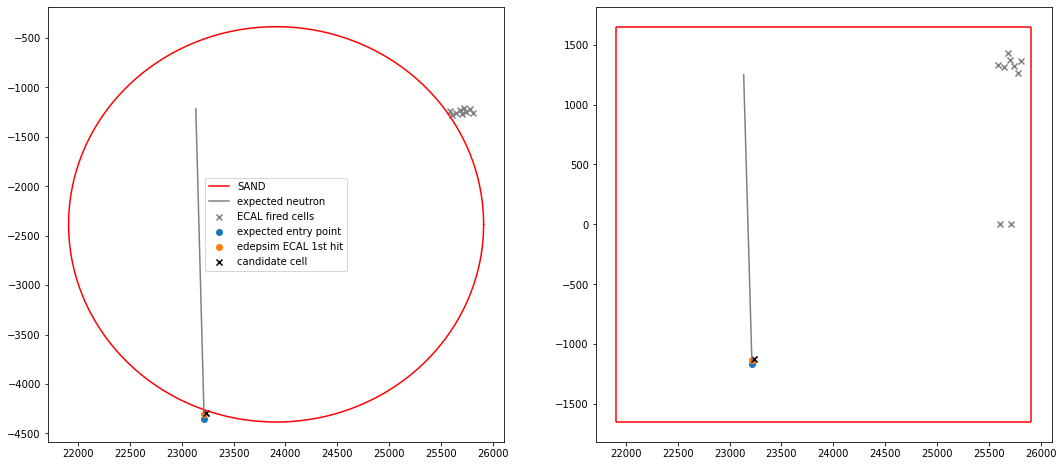

In [16]:
f957 = GetCandidateCell(957)

plotEvent(f957['test_event'], 
          f957['tests_event_primaries'],
          f957['test_event_fired_cells'], 
          f957['best_fired_cell'])

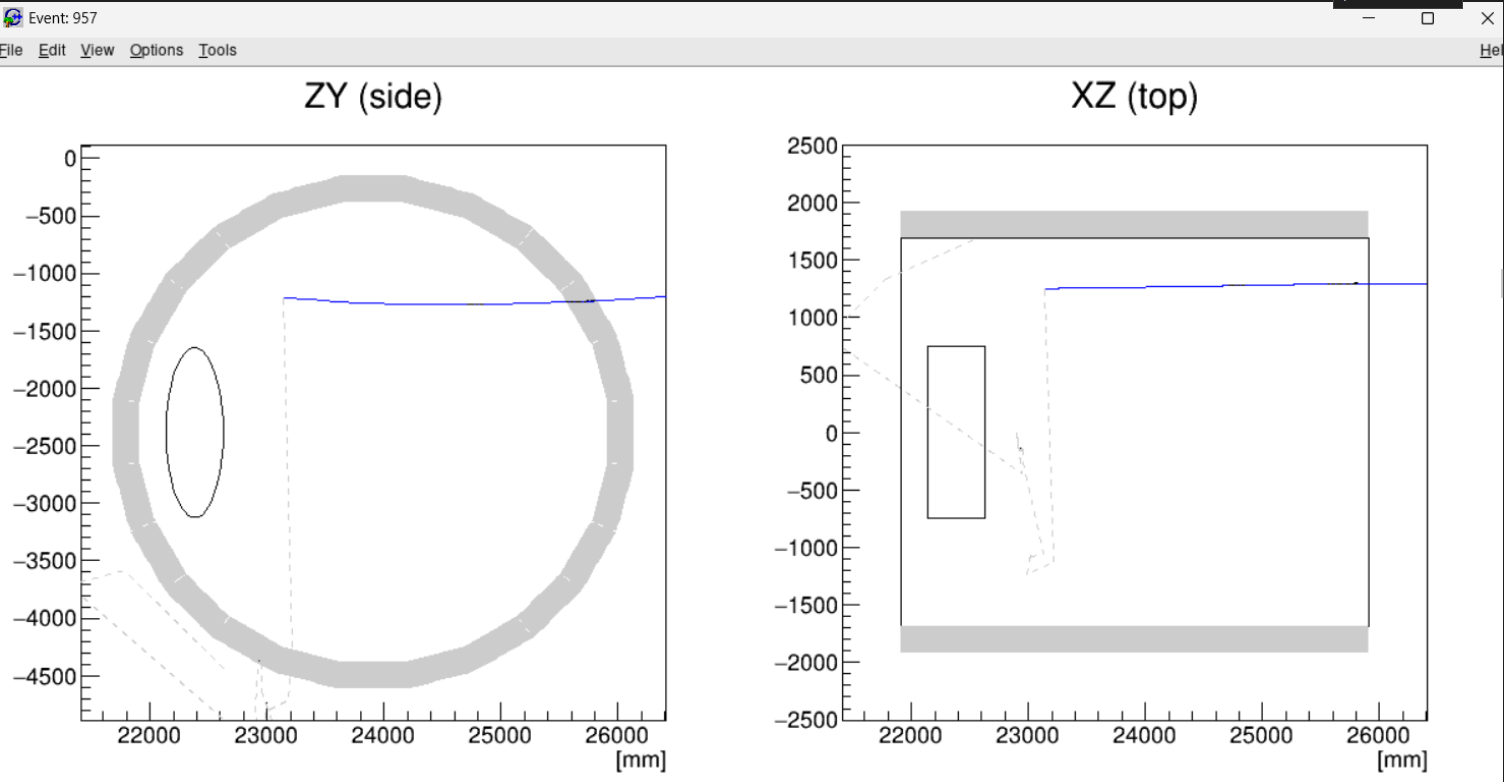

In [22]:
f957['test_event_fired_cells']

FileName  EventId  \
entry subentry                                                               
10    0         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   
      1         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   
      2         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   
      3         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   
      4         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   
      5         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   
      6         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   
      7         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   
      8         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   
      9         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   

                Fired_Cells_mod  Fired_Cells_id  Fired_Cells_x  Fired_Cells_y  \
entry subentry                                                                  
10    0                      11          211002  -4.536223e-13   -4297.755233   
      1                      20          220008   2.348122e-13   -1277.944609   
      2                      20          220009   2.348122e-13   -1239.630453   
      3                      20          220108   2.348122e-13   -1253.852970   
      4                      20          220207   2.348122e-13   -1269.748798   
      5                      20          220208   2.348122e-13   -1229.761330   
      6                      20          220307   2.348122e-13   -1246.493814   
      7                      20          220308   2.348122e-13   -1205.669691   
      8                      20          220406   2.348122e-13   -1262.352073   
      9                      20          220407   2.348122e-13   -1220.596219   

                Fired_Cells_z  isCellComplete  Fired_Cells_tdc1  \
entry subentry                                                    
10    0          23237.099281               1        138.482773   
      1          25605.801645               0         14.383725   
      2          25583.680957               1         15.120925   
      3          25642.699155               1         15.236414   
      4          25702.683439               1         15.350859   
      5          25679.596664               1         14.488866   
      6          25740.063991               1         15.221426   
      7          25716.494173               0         14.651300   
      8          25805.800088               1         16.004390   
      9          25781.692334               1         16.063977   

                Fired_Cells_tdc2    hit_reco_x   hit_reco_y    hit_reco_z  \
entry subentry                                                              
10    0               125.342246 -1.123122e+03 -4297.755233  23237.099281   
      1                 0.000000  2.348122e-13 -1277.944609  25605.801645   
      2                30.660619  1.328179e+03 -1239.630453  25583.680957   
      3                30.580800  1.311486e+03 -1253.852970  25642.699155   
      4                31.370500  1.369200e+03 -1269.748798  25702.683439   
      5                31.178795  1.426490e+03 -1229.761330  25679.596664   
      6                30.687841  1.321916e+03 -1246.493814  25740.063991   
      7                 0.000000  2.348122e-13 -1205.669691  25716.494173   
      8                31.914023  1.359798e+03 -1262.352073  25805.800088   
      9                30.863997  1.264959e+03 -1220.596219  25781.692334   

                hit_reco_t  STDistToNeutronExpectedHit  space_time_distance2  \
entry subentry                                                                 
10    0         119.335010                1.251854e+04         -6.467653e+03   
      1         -12.577500                1.557950e+09         -1.555961e+09   
      2          10.313272                1.055446e+09         -1.053802e+09   
      3          

# event 927

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


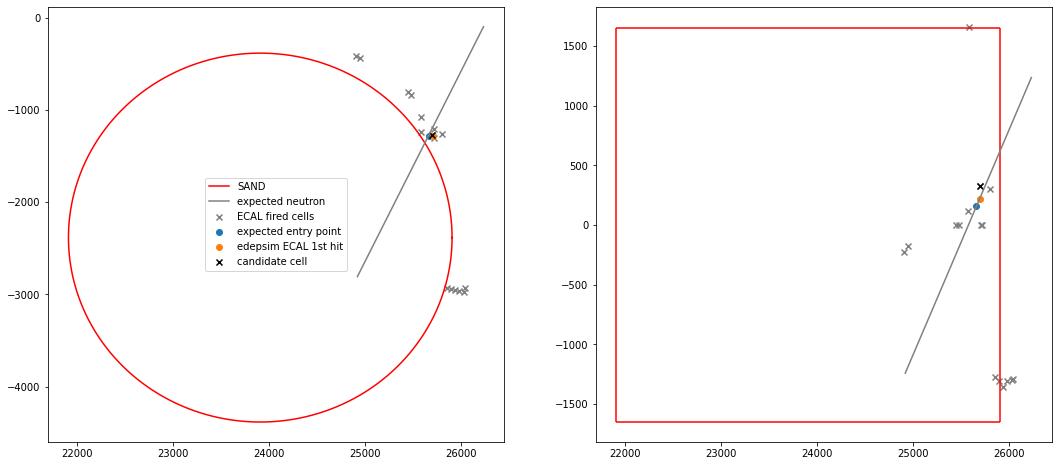

In [25]:
f927 = GetCandidateCell(927)

plotEvent(f927['test_event'], 
          f927['tests_event_primaries'],
          f927['test_event_fired_cells'], 
          f927['best_fired_cell'])

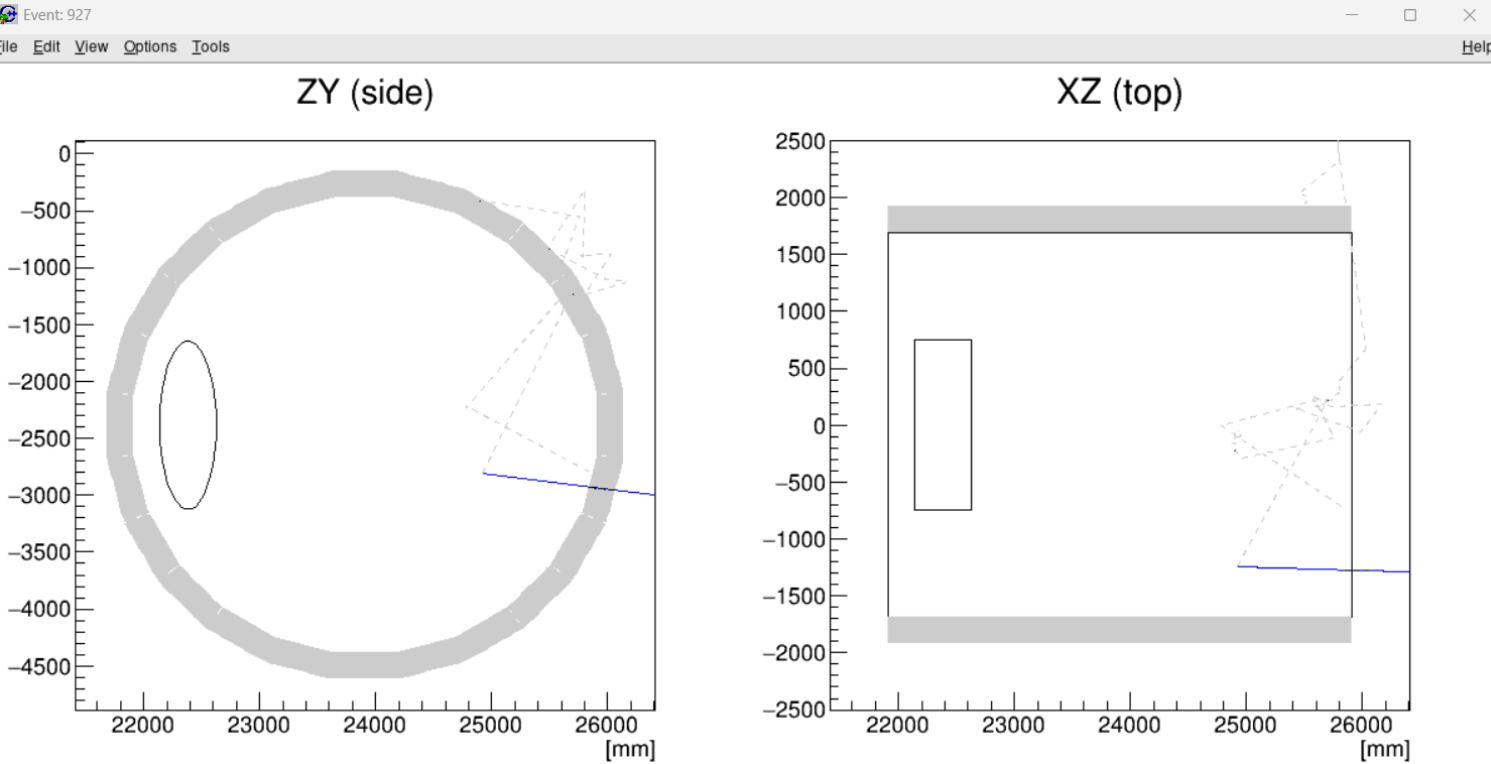

In [27]:
f927['test_event_fired_cells']

FileName  EventId  \
entry subentry                                                               
1     0         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      1         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      2         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      3         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      4         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      5         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      6         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      7         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      8         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      9         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      10        events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      11        events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      12        events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      13        events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      14        events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      15        events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   

                Fired_Cells_mod  Fired_Cells_id  Fired_Cells_x  Fired_Cells_y  \
entry subentry                                                                  
1     0                      17          217005  -1.215477e-13   -2929.429053   
      1                      17          217105  -1.215477e-13   -2941.283676   
      2                      17          217205  -1.215477e-13   -2953.138298   
      3                      17          217305  -1.215477e-13   -2964.992920   
      4                      17          217405  -1.215477e-13   -2978.194658   
      5                      17          217406  -1.215477e-13   -2931.622055   
      6                      20          220009   2.348122e-13   -1239.630453   
      7                      20          220206   2.348122e-13   -1309.736266   
      8                      20          220207   2.348122e-13   -1269.748798   
      9                      20          220308   2.348122e-13   -1205.669691   
      10                     20          220406   2.348122e-13   -1262.352073   
      11                     21          221200   3.320746e-13   -1072.307661   
      12                     21          221405   3.320746e-13    -844.020517   
      13                     21          221406   3.320746e-13    -809.927005   
      14                     22          222407   4.067066e-13    -440.714405   
      15                     22          222408   4.067066e-13    -416.606651   

                Fired_Cells_z  isCellComplete  Fired_Cells_tdc1  \
entry subentry                                                    
1     0          25857.376765               1         25.127447   
      1          25899.752481               1         25.639552   
      2          25942.128196               1         25.982642   
      3          25984.503912               1         26.140111   
      4          26031.695050               1         26.174812   
      5          26044.174141               1         25.996730   
      6          25583.680957               1         41.280563   
      7          25725.770214               0         29.392821   
      8          25702.683439               1         30.380584   
      9          25716.494173               0         31.622960   
      10         25805.800088               1         31.516097   
      11         25581.568278               1         39.108644   
      12         25484.802995               0        316.808993   
      13         25450.709483               0          0.000000   
      14         24948.866219               1        121.065094   
      15         24907.110365               1        1

# event 6

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


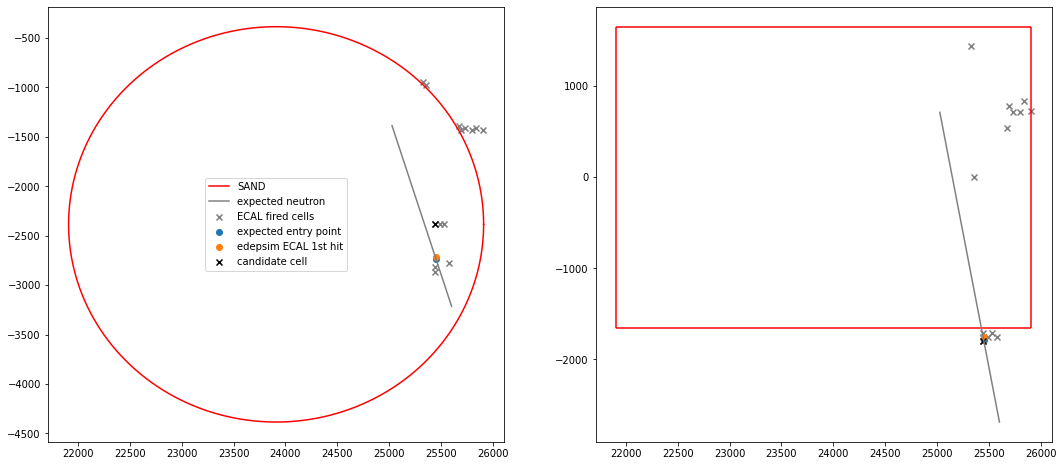

In [12]:
f6 = GetCandidateCell(6)

plotEvent(f6['test_event'], 
          f6['tests_event_primaries'],
          f6['test_event_fired_cells'], 
          f6['best_fired_cell'])

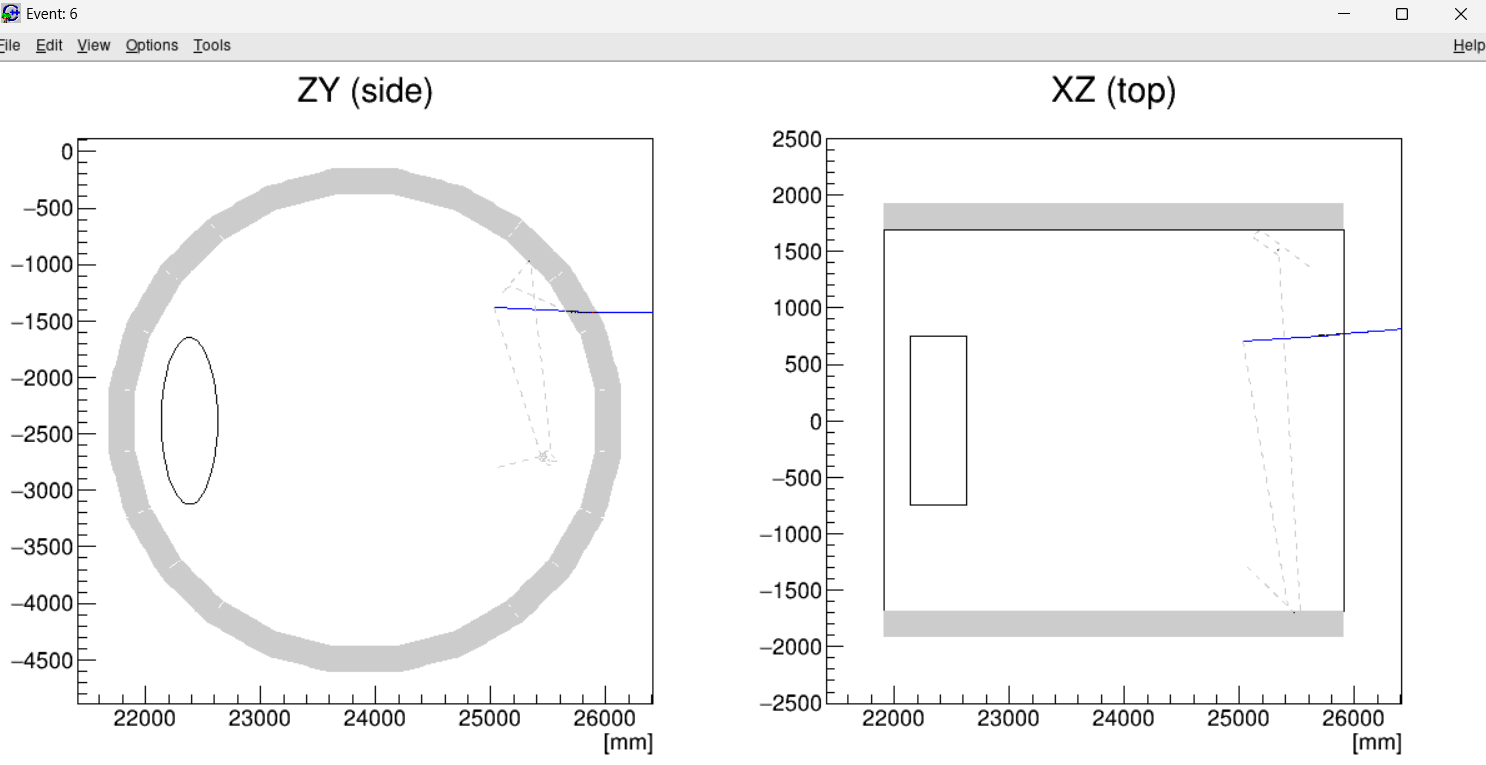

# event 26

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


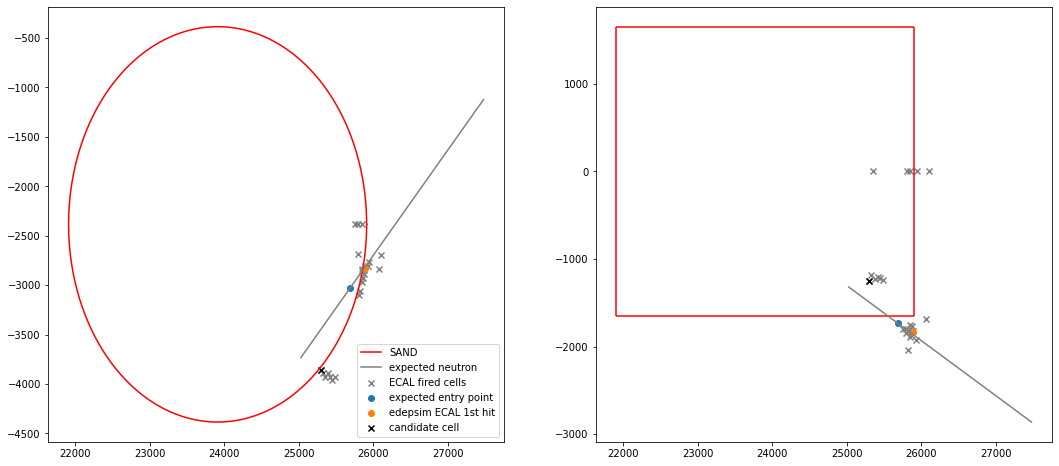

In [13]:
f26 = GetCandidateCell(26)

plotEvent(f26['test_event'], 
          f26['tests_event_primaries'],
          f26['test_event_fired_cells'], 
          f26['best_fired_cell'])

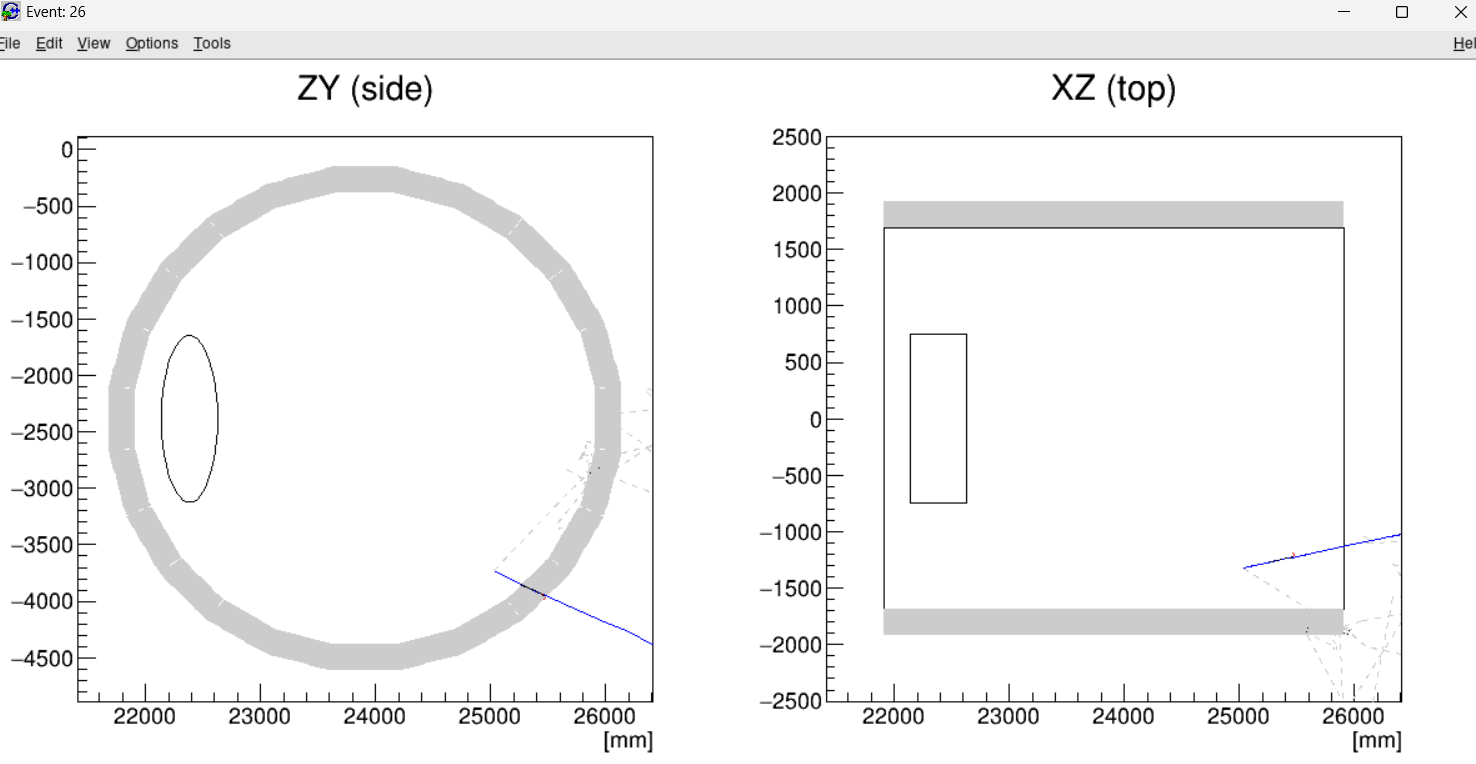

In [14]:
f26['test_event']

,,EventType,CCQEonHydrogen,Interaction_vtxX,Interaction_vtxY,Interaction_vtxZ,PrimaryStateHadronicSystemTotalKinE,ExpectedHadronSystP3fX,ExpectedHadronSystP3fY,ExpectedHadronSystP3fZ,ExpectedNeutronArrivalPositionECALfX,ExpectedNeutronArrivalPositionECALfY,ExpectedNeutronArrivalPositionECALfZ,dist_Vtx2ECAL,ExpectedHadronSystPtot,ExpectedNeutronE,ExpectedNeutronGamma,ExpectedNeutronBeta,ExpectedNeutronCrossingTimeECAL
FileName,EventId,,,,,,,,,,,,,,,,,,
events-in-SANDtracker.2.gtrac.root:gRooTracker:26,26,QES,1,-1.320644,-3.732753,25.027468,0.30424,-0.322022,0.545836,0.512486,-1735.436871,-3029.666541,25687.597212,1049.835106,815.031477,1243.808456,1.323813,0.655271,5.340464


# event 433

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


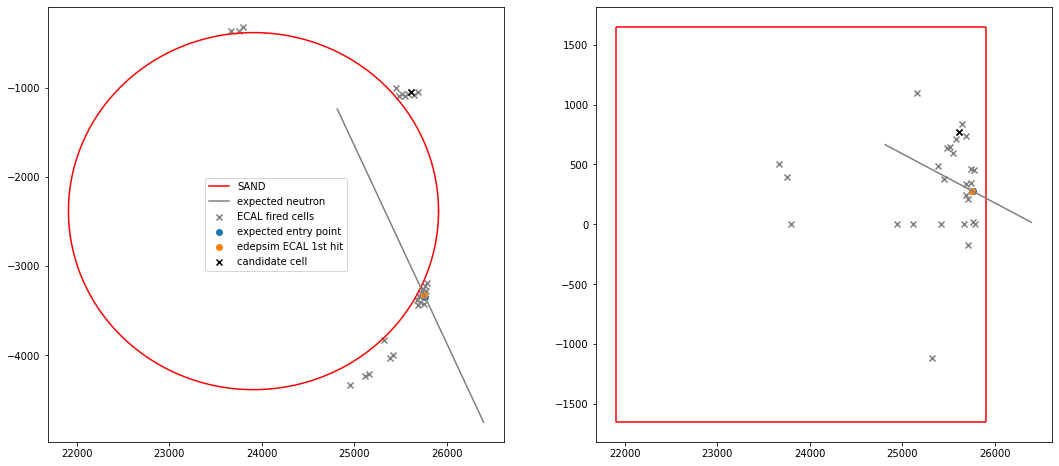

In [15]:
f433 = GetCandidateCell(433)

plotEvent(f433['test_event'], 
          f433['tests_event_primaries'],
          f433['test_event_fired_cells'], 
          f433['best_fired_cell'])

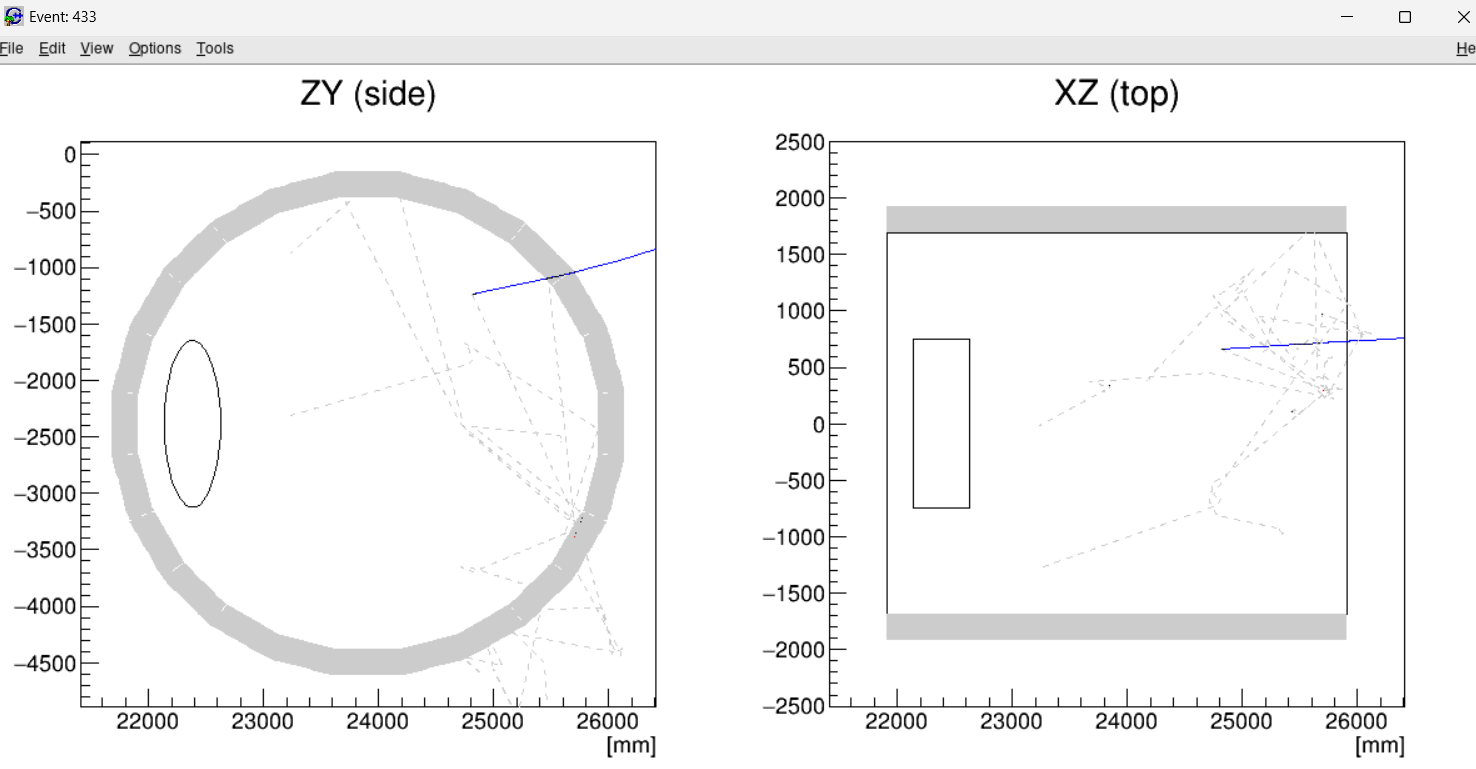

In [16]:
f433['test_event']

,,EventType,CCQEonHydrogen,Interaction_vtxX,Interaction_vtxY,Interaction_vtxZ,PrimaryStateHadronicSystemTotalKinE,ExpectedHadronSystP3fX,ExpectedHadronSystP3fY,ExpectedHadronSystP3fZ,ExpectedNeutronArrivalPositionECALfX,ExpectedNeutronArrivalPositionECALfY,ExpectedNeutronArrivalPositionECALfZ,dist_Vtx2ECAL,ExpectedHadronSystPtot,ExpectedNeutronE,ExpectedNeutronGamma,ExpectedNeutronBeta,ExpectedNeutronCrossingTimeECAL
FileName,EventId,,,,,,,,,,,,,,,,,,
events-in-SANDtracker.2.gtrac.root:gRooTracker:433,433,QES,1,0.665097,-1.241196,24.815954,0.278005,-0.128702,-0.696213,0.313727,276.236733,-3344.741539,25763.851154,2339.791957,774.40402,1217.573304,1.29589,0.636023,12.262627


In [29]:
f433['tests_event_primaries']

EventType  \
FileName                                           EventId             
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433           QES   
                                                   433           QES   

                                                            CCQEonHydrogen  \
FileName                                           EventId                   
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433                   1   
                                                   433                   1   

                                                            Interaction_vtxX  \
FileName                                           EventId                     
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433              0.665097   
                                                   433              0.665097   

                                                            Interaction_vtxY  \
FileName                                           EventId                     
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433             -1.241196   
                                                   433             -1.241196   

                                                            Interaction_vtxZ  \
FileName                                           EventId                     
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433             24.815954   
                                                   433             24.815954   

                                                            Interaction_vtxT  \
FileName                                           EventId                     
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433          7.762681e-09   
                                                   433          7.762681e-09   

                                                             PDG          Px  \
FileName                                           EventId                     
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433       -13  130.539417   
                                                   433      2112 -128.701586   

                                                                    Py  \
FileName                                           EventId               
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433      437.354517   
                                                   433     -696.212556   

                                                                     Pz  ...  \
FileName                                           EventId               ...   
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433      2301.375544  ...   
                                                   433       313.718816  ...   

                                                            PrimariesFirstHitECAL_y  \
FileName                                           EventId                            
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433                 -1102.947637   
                                                   433                 -3327.367169   

                                                            PrimariesFirstHitECAL_z  \
FileName                                           EventId                            
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433                 25457.139737   
                                                   433                 25753.411765   

                                                            PrimariesFirstHitECAL_t  \
FileName                                           EventId                            
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433                     3.193676   
                                                   433                    13.162853   

                                                            PrimariesEDepECAL  \
FileName                                           EventId                      
events-in-SANDtracker.2.g

In [26]:
f433['test_event_fired_cells'][(f433['test_event_fired_cells'].Fired_Cells_mod==16) & (f433['test_event_fired_cells'].Fired_Cells_mod==16)]

FileName  EventId  \
entry subentry                                                               
61    9         events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      10        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      11        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      12        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      13        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      14        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      15        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      16        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      17        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      18        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      19        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   

                Fired_Cells_mod  Fired_Cells_id  Fired_Cells_x  Fired_Cells_y  \
entry subentry                                                                  
61    9                      16          216006  -2.348122e-13   -3376.572922   
      10                     16          216007  -2.348122e-13   -3338.258766   
      11                     16          216008  -2.348122e-13   -3299.944609   
      12                     16          216009  -2.348122e-13   -3261.630453   
      13                     16          216010  -2.348122e-13   -3223.316297   
      14                     16          216011  -2.348122e-13   -3185.002141   
      15                     16          216105  -2.348122e-13   -3437.305406   
      16                     16          216106  -2.348122e-13   -3398.154594   
      17                     16          216108  -2.348122e-13   -3319.852970   
      18                     16          216109  -2.348122e-13   -3280.702158   
      19                     16          216206  -2.348122e-13   -3419.736266   

                Fired_Cells_z  isCellComplete  Fired_Cells_tdc1  \
entry subentry                                                    
61    9          25672.163711               0          0.000000   
      10         25694.284399               1         28.550888   
      11         25716.405087               1         29.775491   
      12         25738.525776               1         26.649303   
      13         25760.646464               1         28.813461   
      14         25782.767153               0          0.000000   
      15         25687.906618               1         36.840850   
      16         25710.510350               1         26.079840   
      17         25755.717814               1         26.125561   
      18         25778.321546               1         29.233913   
      19         25748.856990               1         36.886772   

                Fired_Cells_tdc2    hit_reco_x   hit_reco_y    hit_reco_z  \
entry subentry                                                              
61    9                64.126600 -2.348122e-13 -3376.572922  25672.163711   
      10               31.373364  2.412372e+02 -3338.258766  25694.284399   
      11               27.786163 -1.700280e+02 -3299.944609  25716.405087   
      12               30.682861  3.447485e+02 -3261.630453  25738.525776   
      13               29.021881  1.781367e+01 -3223.316297  25760.646464   
      14               40.110057 -2.348122e-13 -3185.002141  25782.767153   
      15               40.735469  3.328734e+02 -3437.305406  25687.906618   
      16               28.528510  2.092881e+02 -3398.154594  25710.510350   
      17               29.404806  2.802773e+02 -3319.852970  25755.717814   
      18               34.524435  4.521813e+02 -3280.702158  25778.321546   
      19               42.339330  4.660306e+02 -3419.736266  25748.856990   

                hit_reco_t  space_time_distance2  space_time_distance2_abs  
entry subentry                       

# event 513

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


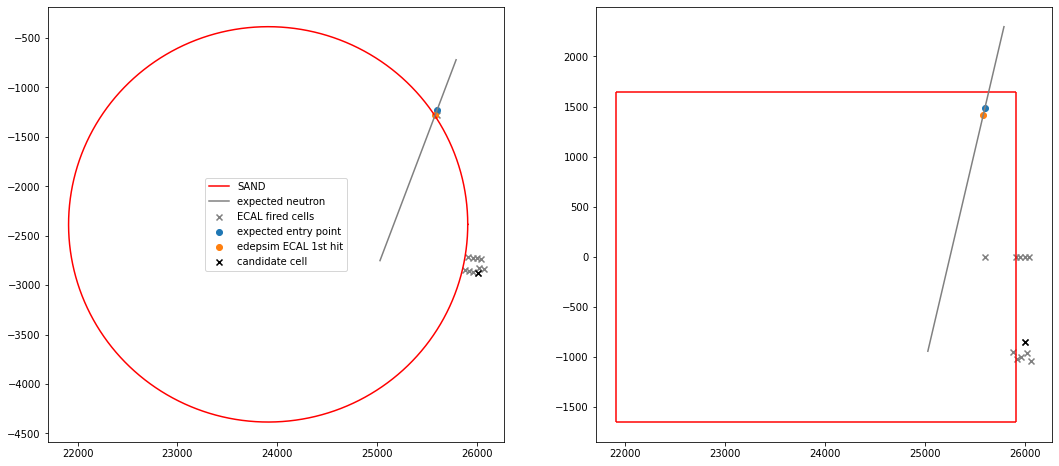

In [18]:
f513 = GetCandidateCell(513)

plotEvent(f513['test_event'], 
          f513['tests_event_primaries'],
          f513['test_event_fired_cells'], 
          f513['best_fired_cell'])

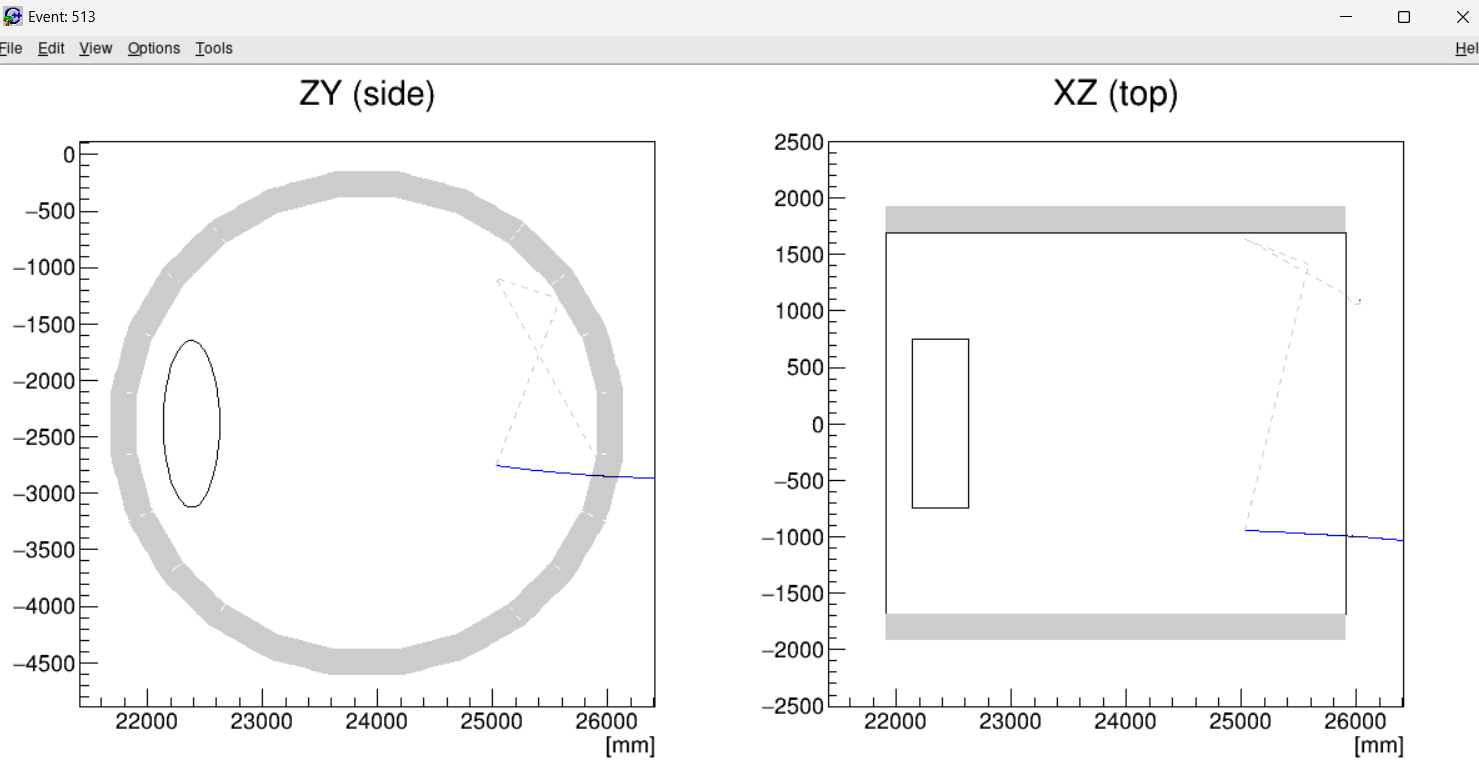

# event 666

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


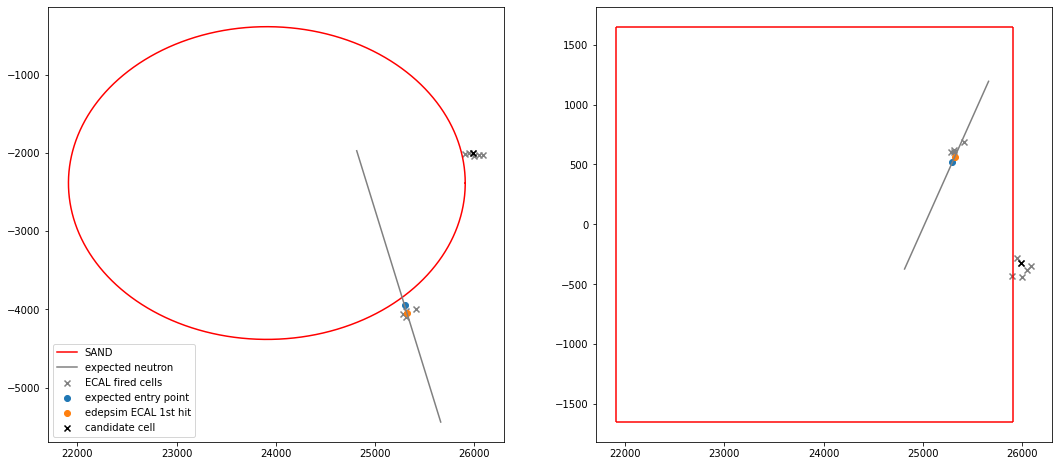

In [19]:
f666 = GetCandidateCell(666)

plotEvent(f666['test_event'], 
          f666['tests_event_primaries'],
          f666['test_event_fired_cells'], 
          f666['best_fired_cell'])

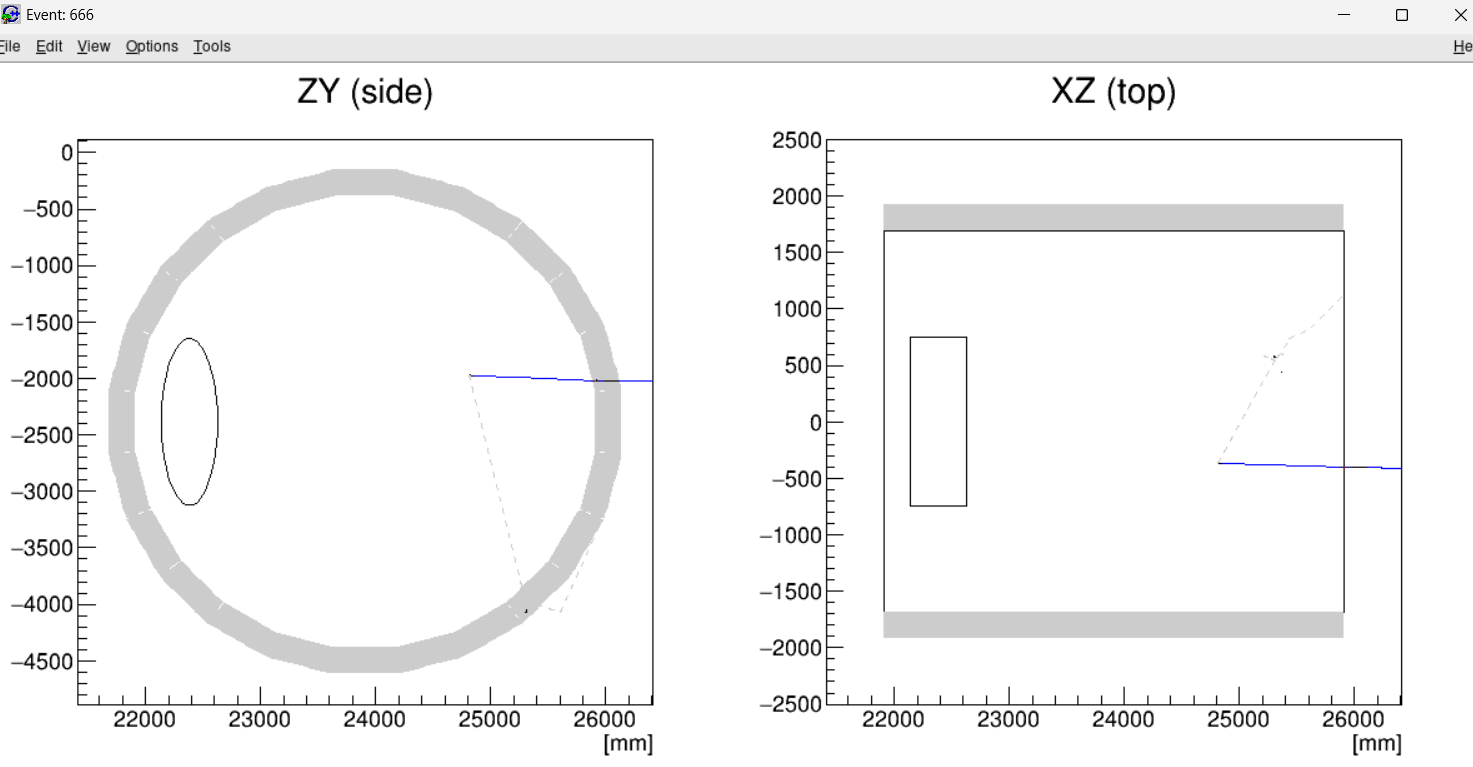

# event 809

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


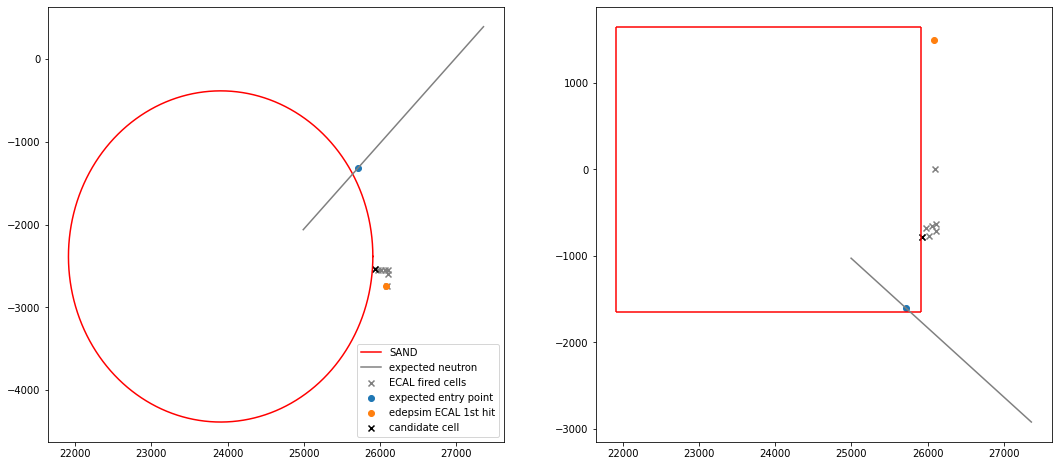

In [20]:
f809 = GetCandidateCell(809)

plotEvent(f809['test_event'], 
          f809['tests_event_primaries'],
          f809['test_event_fired_cells'], 
          f809['best_fired_cell'])

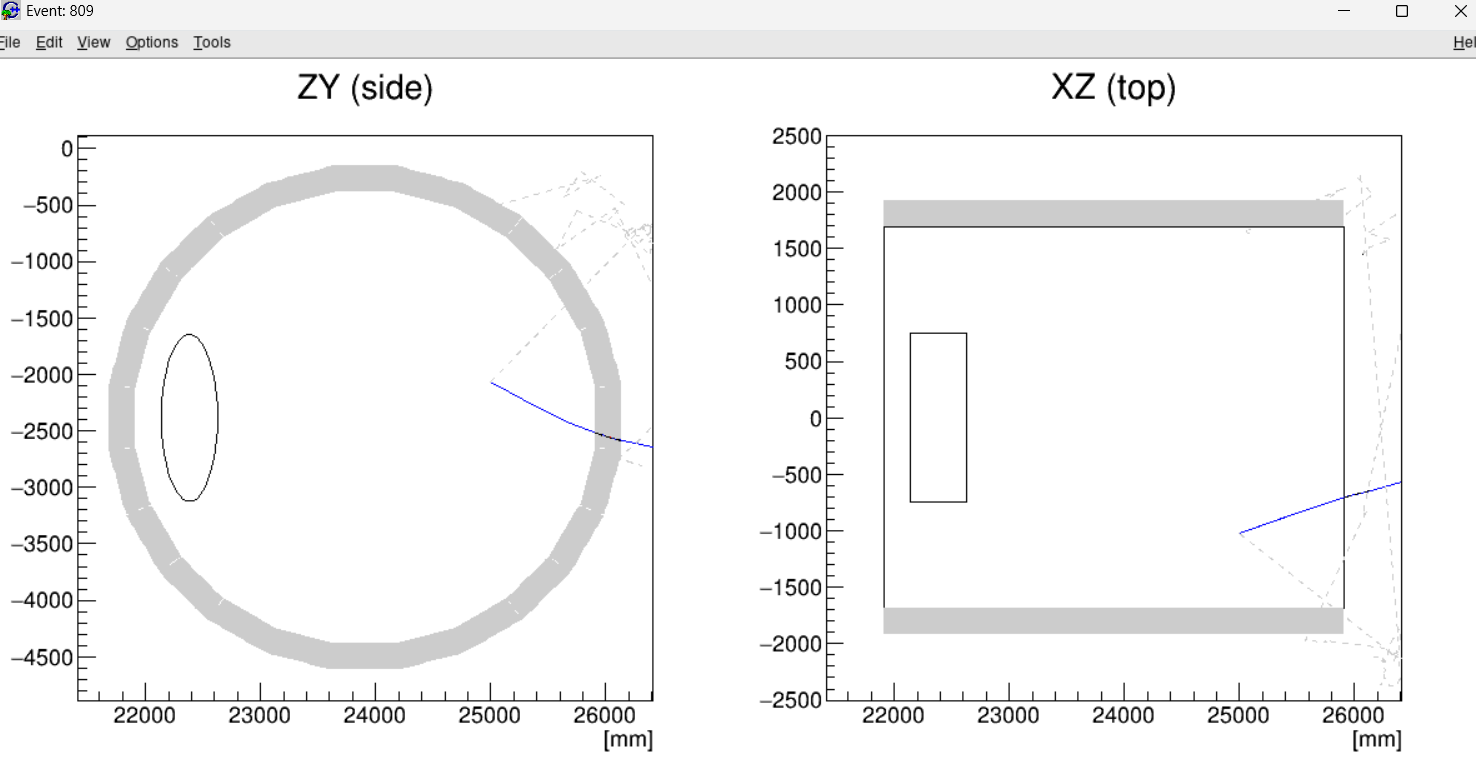

In [94]:
import math

# Constants (placeholders, replace with actual values if needed)
SAND_CENTER_X = 0.0
SAND_CENTER_Y = -2384.73
SAND_CENTER_Z = 23910.
SAND_INNER_VOL_X_LENGTH = 3380.0  # in mm
SAND_INNER_VOL_DIAMETER = 4000.0  # in mm
Module_angle = math.pi / 12.0  # 15 degrees per module
Module_0_starting_angle = (math.pi - Module_angle) * 0.5

def MasterToSAND(point):
    """
    Convert the point coordinates from master coordinates to SAND coordinates.
    """
    return [point[0] - SAND_CENTER_X, 
            point[1] - SAND_CENTER_Y, 
            point[2] - SAND_CENTER_Z]

def GetModuleIdFromPoint(point):
    """
    Given a point in the space, find the ECAL module that contains the point.

    Parameters:
    - units: String representing the unit ('m', 'cm', 'mm').
    - point: A list [x, y, z] representing the point's coordinates.

    Returns:
    - module: The module ID where the point lies.
    """

    # Convert point to SAND coordinates
    Point2SAND = MasterToSAND(point)

    # print("coordinates to SAND : ", Point2SAND)

    # Check if the point is in one of the endcaps
    if Point2SAND[0] <= -SAND_INNER_VOL_X_LENGTH / 2.0:
        return 40
    elif Point2SAND[0] >= SAND_INNER_VOL_X_LENGTH / 2.0:
        return 30
    else:
        angle = math.atan2(Point2SAND[1], Point2SAND[2])
        # print("angle to z axis", angle * 180/math.pi)
        # Rotate coordinates with respect to the Module 0 starting angle
        point_z = Point2SAND[2] * math.cos(Module_0_starting_angle) + Point2SAND[1] * math.sin(Module_0_starting_angle)
        point_y = - Point2SAND[2] * math.sin(Module_0_starting_angle) + Point2SAND[1] * math.cos(Module_0_starting_angle)

        # print(point_y, point_z)

        # Calculate the angle in the YZ plane and adjust to [0, 2π] range
        angle = math.atan2(point_y, point_z)
        # print("angle to z ECAL", angle * 180/math.pi)
        if point_y < 0:
            angle += 2 * math.pi

        # Determine which module the point falls into
        module = int(angle / Module_angle)
        return module



In [102]:
point = [
    SAND_CENTER_X, 
    SAND_CENTER_Y + SAND_INNER_VOL_DIAMETER/2 * np.sin(Module_angle/2), 
    SAND_CENTER_Z + SAND_INNER_VOL_DIAMETER/2 * np.cos(Module_angle/2)
]

# Calcola il modulo
module_id = GetModuleIdFromPoint(point)
print("The point lies in module:", module_id)

The point lies in module: 19


In [64]:
math.sin(Module_0_starting_angle)

0.9914448613738104

In [103]:
c = []
for i, row in fired_cells[['Fired_Cells_x','Fired_Cells_y','Fired_Cells_z','Fired_Cells_mod']].iterrows():
    point = [row.Fired_Cells_x, row.Fired_Cells_y, row.Fired_Cells_z]
    c.append(GetModuleIdFromPoint(point))
    # print(f'id : {row.Fired_Cells_mod}, calculated : {GetModuleIdFromPoint(point)}')

In [107]:
(fired_cells.Fired_Cells_mod.values - np.array(c)).sum()

0